In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import gc
import pickle
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

In [2]:
## Function to reduce the memory usage
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics: 
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased from {:5.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)'.format(start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
# read data from file:
train_set0 = pd.read_csv('C:/data/Kaggle_ASHRAE_energy/train_set0.csv')
train_set0 = reduce_mem_usage(train_set0)
train_set1 = pd.read_csv('C:/data/Kaggle_ASHRAE_energy/train_set1.csv')
train_set1 = reduce_mem_usage(train_set1)
train_set2 = pd.read_csv('C:/data/Kaggle_ASHRAE_energy/train_set2.csv')
train_set2 = reduce_mem_usage(train_set2)
train_set3 = pd.read_csv('C:/data/Kaggle_ASHRAE_energy/train_set3.csv')
train_set3 = reduce_mem_usage(train_set3)

Mem. usage decreased from 1603.49 Mb to 523.36 Mb (67.4% reduction)
Mem. usage decreased from 571.30 Mb to 194.40 Mb (66.0% reduction)
Mem. usage decreased from 368.96 Mb to 125.55 Mb (66.0% reduction)
Mem. usage decreased from 173.23 Mb to 58.95 Mb (66.0% reduction)


In [4]:
'''train_set0.timestamp = pd.to_datetime(train_set0.timestamp)
train_set1.timestamp = pd.to_datetime(train_set1.timestamp)
train_set2.timestamp = pd.to_datetime(train_set2.timestamp)
train_set3.timestamp = pd.to_datetime(train_set3.timestamp)'''

'train_set0.timestamp = pd.to_datetime(train_set0.timestamp)\ntrain_set1.timestamp = pd.to_datetime(train_set1.timestamp)\ntrain_set2.timestamp = pd.to_datetime(train_set2.timestamp)\ntrain_set3.timestamp = pd.to_datetime(train_set3.timestamp)'

In [4]:
train_set0.shape, train_set1.shape, train_set2.shape, train_set3.shape

((11676263, 18), (4160090, 18), (2686678, 18), (1261421, 18))

In [5]:
train_set0.head()

,site_id,building_id,primary_use,square_feet,timestamp,airtemp,sealev,dewtemp,windsp,North,West,South,nowind,dewair,month,weekday,hour,meter_reading
0,0,0,Education,0.008171,2016-05-20 18:00:00,0.698242,0.606934,0.863770,0.425537,0.0,0.0,0.0,0.0,0.120483,5.0,4.0,18.0,68.2500
1,0,0,Education,0.008171,2016-05-20 19:00:00,0.706055,0.597168,0.873535,0.235596,0.0,0.0,0.0,0.0,0.120483,5.0,4.0,19.0,81.4375
2,0,0,Education,0.008171,2016-05-20 20:00:00,0.740723,0.595703,0.881836,0.148804,0.0,0.0,0.0,0.0,0.158325,5.0,4.0,20.0,70.0000
3,0,0,Education,0.008171,2016-05-20 21:00:00,0.763184,0.589844,0.873535,0.210693,1.0,0.0,0.0,0.0,0.196167,5.0,4.0,21.0,70.6250
4,0,0,Education,0.008171,2016-05-20 22:00:00,0.734375,0.584961,0.891602,0.235596,1.0,0.0,0.0,0.0,0.139404,5.0,4.0,22.0,74.0000


In [6]:
# labelEncode primary_use
le = LabelEncoder()
train_set0["primary_use"] = le.fit_transform(train_set0["primary_use"])
train_set1["primary_use"] = le.transform(train_set1["primary_use"])
train_set2["primary_use"] = le.transform(train_set2["primary_use"])
train_set3["primary_use"] = le.transform(train_set3["primary_use"])

In [14]:
pickle.dump(le, open('LabelEncoder_primary_use.pkl', 'wb'))

In [7]:
# replace month = 12 with 0
train_set0.month[train_set0.month==12] = 0
train_set1.month[train_set1.month==12] = 0
train_set2.month[train_set2.month==12] = 0
train_set3.month[train_set3.month==12] = 0

C:\Users\raymond.guo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\raymond.guo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raymond.guo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas

In [8]:
# need to rescale the meter_reading:
rob_0 = RobustScaler()
mm_0 = MinMaxScaler()
rob_1 = RobustScaler()
mm_1 = MinMaxScaler()
rob_2 = RobustScaler()
mm_2 = MinMaxScaler()
rob_3 = RobustScaler()
mm_3 = MinMaxScaler()

In [9]:
train_set0.meter_reading = mm_0.fit_transform(rob_0.fit_transform(np.log1p(train_set0.meter_reading).values.reshape(-1,1)))
train_set1.meter_reading = mm_1.fit_transform(rob_1.fit_transform(np.log1p(train_set1.meter_reading).values.reshape(-1,1)))
train_set2.meter_reading = mm_2.fit_transform(rob_2.fit_transform(np.log1p(train_set2.meter_reading).values.reshape(-1,1)))
train_set3.meter_reading = mm_3.fit_transform(rob_3.fit_transform(np.log1p(train_set3.meter_reading).values.reshape(-1,1)))

In [16]:
pickle.dump(mm_0, open('mm_0.pkl', 'wb'))
pickle.dump(rob_0, open('rob_0.pkl', 'wb'))
pickle.dump(mm_1, open('mm_1.pkl', 'wb'))
pickle.dump(rob_1, open('rob_1.pkl', 'wb'))
pickle.dump(mm_2, open('mm_2.pkl', 'wb'))
pickle.dump(rob_2, open('rob_2.pkl', 'wb'))
pickle.dump(mm_3, open('mm_3.pkl', 'wb'))
pickle.dump(rob_3, open('rob_3.pkl', 'wb'))

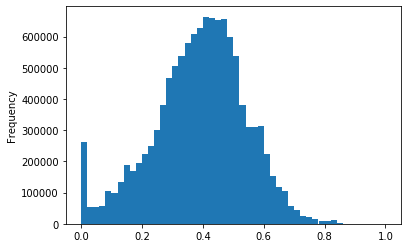

In [12]:
train_set0.meter_reading.plot.hist(bins=50)

In [12]:
train_set0.head()

,site_id,building_id,primary_use,square_feet,timestamp,airtemp,sealev,dewtemp,windsp,North,West,South,nowind,dewair,month,weekday,hour,meter_reading
0,0,0,0,0.008171,2016-05-20 18:00:00,0.698242,0.606934,0.863770,0.425537,0.0,0.0,0.0,0.0,0.120483,5.0,4.0,18.0,0.408936
1,0,0,0,0.008171,2016-05-20 19:00:00,0.706055,0.597168,0.873535,0.235596,0.0,0.0,0.0,0.0,0.120483,5.0,4.0,19.0,0.425537
2,0,0,0,0.008171,2016-05-20 20:00:00,0.740723,0.595703,0.881836,0.148804,0.0,0.0,0.0,0.0,0.158325,5.0,4.0,20.0,0.411133
3,0,0,0,0.008171,2016-05-20 21:00:00,0.763184,0.589844,0.873535,0.210693,1.0,0.0,0.0,0.0,0.196167,5.0,4.0,21.0,0.411865
4,0,0,0,0.008171,2016-05-20 22:00:00,0.734375,0.584961,0.891602,0.235596,1.0,0.0,0.0,0.0,0.139404,5.0,4.0,22.0,0.416504


all training data is prepared, now we need to split test_set and new train_set from original train_set

In [32]:
%%time
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size = 0.1, random_state=99)
for train_index, test_index in split.split(train_set0, train_set0.building_id):
    strat_train_set0 = train_set0.loc[train_index]
    strat_test_set0 = train_set0.loc[test_index]
for train_index, test_index in split.split(train_set1, train_set1.building_id):
    strat_train_set1 = train_set1.loc[train_index]
    strat_test_set1 = train_set1.loc[test_index]
for train_index, test_index in split.split(train_set2, train_set2.building_id):
    strat_train_set2 = train_set2.loc[train_index]
    strat_test_set2 = train_set2.loc[test_index]
for train_index, test_index in split.split(train_set3, train_set3.building_id):
    strat_train_set3 = train_set3.loc[train_index]
    strat_test_set3 = train_set3.loc[test_index]

Wall time: 18.7 s


In [33]:
strat_train_set0.head()

,site_id,building_id,primary_use,square_feet,timestamp,airtemp,sealev,dewtemp,windsp,North,West,South,nowind,dewair,month,weekday,hour,meter_reading
2109112,2,280,1,0.120300,2016-10-21 14:00:00,0.676270,0.553223,0.630371,0.169434,1.0,0.0,0.0,0.0,0.339111,10.0,4.0,14.0,0.502441
125683,0,23,0,0.149292,2016-05-23 13:00:00,0.698242,0.561523,0.863770,0.107422,0.0,0.0,0.0,0.0,0.120483,5.0,0.0,13.0,0.549316
5977866,5,731,0,0.032990,2016-10-20 01:00:00,0.465088,0.554199,0.664551,0.061981,0.0,0.0,0.0,0.0,0.022369,10.0,3.0,1.0,0.180542
6091799,5,744,1,0.055298,2016-10-24 23:00:00,0.503906,0.554199,0.729492,0.210693,1.0,0.0,0.0,0.0,0.005165,10.0,0.0,23.0,0.261963
7026077,8,867,9,0.075012,2016-04-28 18:00:00,0.785156,0.576172,0.846191,0.061981,0.0,0.0,1.0,0.0,0.254639,4.0,3.0,18.0,0.469727


In [17]:
del train_set0
del train_set1
del train_set2
del train_set3
gc.collect()

8335

In [35]:
X0 = [strat_train_set0.building_id.values, strat_train_set0.primary_use.values, 
      strat_train_set0.month.values, strat_train_set0.weekday.values, strat_train_set0.hour.values, 
      strat_train_set0.drop(['site_id','building_id','timestamp','meter_reading','dewair'], axis=1).values]
y0 = strat_train_set0.meter_reading.values

X1 = [strat_train_set1.building_id.values, strat_train_set1.primary_use.values, 
      strat_train_set1.month.values, strat_train_set1.weekday.values, strat_train_set1.hour.values, 
      strat_train_set1.drop(['site_id','building_id','timestamp','meter_reading','dewair'], axis=1).values]
y1 = strat_train_set1.meter_reading.values

X2 = [strat_train_set2.building_id.values, strat_train_set2.primary_use.values, 
      strat_train_set2.month.values, strat_train_set2.weekday.values, strat_train_set2.hour.values, 
      strat_train_set2.drop(['site_id','building_id','timestamp','meter_reading','dewair'], axis=1).values]
y2 = strat_train_set2.meter_reading.values

X3 = [strat_train_set3.building_id.values, strat_train_set3.primary_use.values, 
      strat_train_set3.month.values, strat_train_set3.weekday.values, strat_train_set3.hour.values, 
      strat_train_set3.drop(['site_id','building_id','timestamp','meter_reading','dewair'], axis=1).values]
y3 = strat_train_set3.meter_reading.values

In [36]:
X0_test = [strat_test_set0.building_id.values, strat_test_set0.primary_use.values, 
      strat_test_set0.month.values, strat_test_set0.weekday.values, strat_test_set0.hour.values, 
      strat_test_set0.drop(['site_id','building_id','timestamp','meter_reading','dewair'], axis=1).values]
y0_test = strat_test_set0.meter_reading.values

X1_test = [strat_test_set1.building_id.values, strat_test_set1.primary_use.values, 
      strat_test_set1.month.values, strat_test_set1.weekday.values, strat_test_set1.hour.values, 
      strat_test_set1.drop(['site_id','building_id','timestamp','meter_reading','dewair'], axis=1).values]
y1_test = strat_test_set1.meter_reading.values

X2_test = [strat_test_set2.building_id.values, strat_test_set2.primary_use.values, 
      strat_test_set2.month.values, strat_test_set2.weekday.values, strat_test_set2.hour.values, 
      strat_test_set2.drop(['site_id','building_id','timestamp','meter_reading','dewair'], axis=1).values]
y2_test = strat_test_set2.meter_reading.values

X3_test = [strat_test_set3.building_id.values, strat_test_set3.primary_use.values, 
      strat_test_set3.month.values, strat_test_set3.weekday.values, strat_test_set3.hour.values, 
      strat_test_set3.drop(['site_id','building_id','timestamp','meter_reading','dewair'], axis=1).values]
y3_test = strat_test_set3.meter_reading.values

In [12]:
def build_model():
    
    embeddings = []
    
    input_building_id = tf.keras.layers.Input(shape=(1,), name='input_building_id')
    building_id_emb = tf.keras.layers.Embedding(1449, 20, name = 'building_id_emb')(input_building_id)
    building_id_emb = tf.keras.layers.Flatten()(building_id_emb)
    building_id_emb = tf.keras.layers.BatchNormalization()(building_id_emb)
    building_id_emb = tf.keras.layers.Dropout(0.2)(building_id_emb)
    building_id_emb = tf.keras.layers.Dense(10, activation='relu')(building_id_emb)
    
    embeddings.append(building_id_emb)
    
    input_primary_use = tf.keras.layers.Input(shape=(1,), name='input_primary_use')
    primary_use_emb = tf.keras.layers.Embedding(16, 5, name = 'primary_use_emb')(input_primary_use)
    primary_use_emb = tf.keras.layers.Flatten()(primary_use_emb)
    primary_use_emb = tf.keras.layers.BatchNormalization()(primary_use_emb)
    primary_use_emb = tf.keras.layers.Dropout(0.1)(primary_use_emb)
    primary_use_emb = tf.keras.layers.Dense(2, activation='relu')(primary_use_emb)

    embeddings.append(primary_use_emb)
    
    input_month = tf.keras.layers.Input(shape=(1,), name='input_month')
    month_emb = tf.keras.layers.Embedding(12, 4, name = 'month_emb')(input_month)
    month_emb = tf.keras.layers.Flatten()(month_emb)
    month_emb = tf.keras.layers.BatchNormalization()(month_emb)
    month_emb = tf.keras.layers.Dropout(0.1)(month_emb)
    month_emb = tf.keras.layers.Dense(2, activation='relu')(month_emb)

    embeddings.append(month_emb)
    
    input_weekday = tf.keras.layers.Input(shape=(1,), name='input_weekday')
    weekday_emb = tf.keras.layers.Embedding(7, 3, name = 'month_emb')(input_weekday)
    weekday_emb = tf.keras.layers.Flatten()(weekday_emb)
    weekday_emb = tf.keras.layers.BatchNormalization()(weekday_emb)
    weekday_emb = tf.keras.layers.Dense(2, activation='relu')(weekday_emb)

    embeddings.append(month_emb)
    
    input_hour = tf.keras.layers.Input(shape=(1,), name='input_hour')
    hour_emb = tf.keras.layers.Embedding(24, 6, name = 'hour_emb')(input_hour)
    hour_emb = tf.keras.layers.Flatten()(hour_emb)
    hour_emb = tf.keras.layers.BatchNormalization()(hour_emb)
    hour_emb = tf.keras.layers.Dense(3, activation='relu')(hour_emb)

    embeddings.append(hour_emb)

    
    input_numeric = tf.keras.layers.Input(shape=(13,), name = 'input_numeric')
#    embedding_num = tf.keras.layers.Dense(35)(input_numeric)
    
    embeddings.append(input_numeric)
    
    main_Layers = tf.keras.layers.Concatenate()(embeddings)
    
    # input size = 32
    main_Layers = tf.keras.layers.Dense(50, activation='relu')(main_Layers)
    main_Layers = tf.keras.layers.BatchNormalization()(main_Layers)
    main_Layers = tf.keras.layers.Dropout(0.05)(main_Layers)
    main_Layers = tf.keras.layers.Dense(20, activation='relu')(main_Layers)
    main_Layers = tf.keras.layers.BatchNormalization()(main_Layers)
    main_Layers = tf.keras.layers.Dropout(0.05)(main_Layers)
    main_Layers = tf.keras.layers.Dense(5, activation='relu')(main_Layers)
    main_Layers = tf.keras.layers.BatchNormalization()(main_Layers)
    main_Layers = tf.keras.layers.Dropout(0.05)(main_Layers)
    output = tf.keras.layers.Dense(1)(main_Layers)

    model = tf.keras.Model([input_building_id, input_primary_use, input_month,
                            input_weekday, input_hour, input_numeric], output)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001,beta_1=0.9,beta_2=0.999, epsilon=1e-08), 
                  loss='mse' # tf.keras.losses.mean_squared_error
                  , metrics=['mae']
                 )
    return model

In [13]:
model_meter0 = build_model()
model_meter1 = build_model()
model_meter2 = build_model()
model_meter3 = build_model()

In [14]:
model_meter0.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_building_id (InputLayer)  [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_primary_use (InputLayer)  [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_month (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
building_id_emb (Embedding)     (None, 1, 20)        28980       input_building_id[0][0]          
______________________________________________________________________________________________

In [57]:
history = model_meter0.fit(X0, y0, epochs=3
                           , batch_size=64
#                          , verbose=0
                          )

Train on 10508636 samples
Epoch 1/3
10508636/10508636 [==============================] - 852s 81us/sample - loss: 0.0044 - mae: 0.0400
Epoch 2/3
10508636/10508636 [==============================] - 834s 79us/sample - loss: 0.0032 - mae: 0.0359
Epoch 3/3
10508636/10508636 [==============================] - 839s 80us/sample - loss: 0.0032 - mae: 0.0354


In [ ]:
# model1.evaluate(X_test, y_test)

Wall time: 0 ns


In [63]:
test_pred = model_meter0.predict(X0_test)

In [64]:
test_rmse = np.sqrt(mean_squared_error(y0_test, test_pred))
print(test_rmse)

0.048293296


In [43]:
history = model_meter1.fit(X1, y1, epochs=3
                           , batch_size=64
#                          , verbose=0
                          )

Train on 3744081 samples
Epoch 1/3
3744081/3744081 [==============================] - 187s 50us/sample - loss: 0.0078 - mae: 0.0571
Epoch 2/3
3744081/3744081 [==============================] - 203s 54us/sample - loss: 0.0077 - mae: 0.0566
Epoch 3/3
3744081/3744081 [==============================] - 204s 55us/sample - loss: 0.0076 - mae: 0.0565


In [44]:
history = model_meter2.fit(X2, y2, epochs=6
                           , batch_size=64
#                          , verbose=0
                          )

Train on 2418010 samples
Epoch 1/6
2418010/2418010 [==============================] - 136s 56us/sample - loss: 0.0059 - mae: 0.0497
Epoch 2/6
2418010/2418010 [==============================] - 132s 55us/sample - loss: 0.0058 - mae: 0.0492
Epoch 3/6
2418010/2418010 [==============================] - 131s 54us/sample - loss: 0.0058 - mae: 0.0490
Epoch 4/6
2418010/2418010 [==============================] - 129s 54us/sample - loss: 0.0058 - mae: 0.0489
Epoch 5/6
2418010/2418010 [==============================] - 130s 54us/sample - loss: 0.0057 - mae: 0.0487
Epoch 6/6
2418010/2418010 [==============================] - 129s 53us/sample - loss: 0.0057 - mae: 0.0486


In [45]:
history = model_meter3.fit(X3, y3, epochs=20
                           , batch_size=64
#                          , verbose=0
                          )

Train on 1135278 samples
Epoch 1/20
1135278/1135278 [==============================] - 59s 52us/sample - loss: 0.0138 - mae: 0.0781
Epoch 2/20
1135278/1135278 [==============================] - 71s 63us/sample - loss: 0.0137 - mae: 0.0776
Epoch 3/20
1135278/1135278 [==============================] - 57s 51us/sample - loss: 0.0136 - mae: 0.0771
Epoch 4/20
1135278/1135278 [==============================] - 71s 62us/sample - loss: 0.0135 - mae: 0.0770
Epoch 5/20
1135278/1135278 [==============================] - 72s 63us/sample - loss: 0.0135 - mae: 0.0766
Epoch 6/20
1135278/1135278 [==============================] - 71s 63us/sample - loss: 0.0134 - mae: 0.0764
Epoch 7/20
1135278/1135278 [==============================] - 73s 64us/sample - loss: 0.0134 - mae: 0.0763
Epoch 8/20
1135278/1135278 [==============================] - 57s 50us/sample - loss: 0.0133 - mae: 0.0762
Epoch 9/20
1135278/1135278 [==============================] - 59s 52us/sample - loss: 0.0133 - mae: 0.0761
Epoch 10/20


In [46]:
model_meter0.save('model_meter0.h5')
model_meter1.save('model_meter1.h5')
model_meter2.save('model_meter2.h5')
model_meter3.save('model_meter3.h5')

In [47]:
## list memory taken of objects
import sys
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']
# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x)) / 1024**2) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('strat_train_set0', 1192.5961570739746),
 ('strat_train_set1', 432.0467233657837),
 ('strat_train_set2', 279.02530097961426),
 ('strat_test_set0', 132.51079273223877),
 ('strat_train_set3', 131.0049648284912),
 ('strat_test_set1', 48.00521183013916),
 ('strat_test_set2', 31.002857208251953),
 ('strat_test_set3', 14.556242942810059),
 ('train_index', 8.661575317382812),
 ('test_index', 0.9624862670898438),
 ('LabelEncoder', 0.001007080078125),
 ('StratifiedShuffleSplit', 0.001007080078125),
 ('MinMaxScaler', 0.00084686279296875),
 ('RobustScaler', 0.00084686279296875),
 ('build_model', 0.00012969970703125),
 ('reduce_mem_usage', 0.00012969970703125),
 ('X0', 0.0001068115234375),
 ('X0_test', 0.0001068115234375),
 ('X1', 0.0001068115234375),
 ('X1_test', 0.0001068115234375),
 ('X2', 0.0001068115234375),
 ('X2_test', 0.0001068115234375),
 ('X3', 0.0001068115234375),
 ('X3_test', 0.0001068115234375),
 ('y0', 9.1552734375e-05),
 ('y0_test', 9.1552734375e-05),
 ('y1', 9.1552734375e-05),
 (

In [51]:
del strat_train_set0
del strat_train_set1
del strat_train_set2
del strat_train_set3
del strat_test_set0
del strat_test_set1
del strat_test_set2
del strat_test_set3
gc.collect()

NameError: name 'strat_train_set0' is not defined

### predict the submit sets

In [3]:
le = pickle.load(open('LabelEncoder_primary_use.pkl', 'rb'))
rob_0 = pickle.load(open('rob_0.pkl', 'rb'))
mm_0 = pickle.load(open('mm_0.pkl', 'rb'))
rob_1 = pickle.load(open('rob_1.pkl', 'rb'))
mm_1 = pickle.load(open('mm_1.pkl', 'rb'))
rob_2 = pickle.load(open('rob_2.pkl', 'rb'))
mm_2 = pickle.load(open('mm_2.pkl', 'rb'))
rob_3 = pickle.load(open('rob_3.pkl', 'rb'))
mm_3 = pickle.load(open('mm_3.pkl', 'rb'))

##### predict submit set with meter 0

In [10]:
# read data from file:
submit_set0 = pd.read_csv('C:/data/Kaggle_ASHRAE_energy/test_set0.csv')
submit_set0 = reduce_mem_usage(submit_set0)

Mem. usage decreased from 3385.10 Mb to 1151.87 Mb (66.0% reduction)


In [11]:
submit_set0["primary_use"] = le.transform(submit_set0["primary_use"])

In [12]:
# replace month = 12 with 0
submit_set0.month[submit_set0.month==12] = 0

C:\Users\raymond.guo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
submit_set0

,site_id,building_id,primary_use,square_feet,timestamp,airtemp,sealev,dewtemp,windsp,North,West,South,nowind,dewair,month,weekday,hour,row_id
0,0,0,0,0.008171,2017-01-01 00:00:00,0.604980,0.649414,0.756836,0.148804,1.0,0.0,0.0,0.0,0.110168,1.0,6.0,0.0,0
1,0,0,0,0.008171,2017-01-01 01:00:00,0.604980,0.656738,0.774902,0.128052,1.0,0.0,0.0,0.0,0.091248,1.0,6.0,1.0,129
2,0,0,0,0.008171,2017-01-01 02:00:00,0.583008,0.655762,0.774902,0.128052,0.0,0.0,1.0,0.0,0.061951,1.0,6.0,2.0,258
3,0,0,0,0.008171,2017-01-01 03:00:00,0.597168,0.659180,0.782715,0.128052,0.0,0.0,1.0,0.0,0.072266,1.0,6.0,3.0,387
4,0,0,0,0.008171,2017-01-01 04:00:00,0.590820,0.660645,0.782715,0.107422,1.0,0.0,0.0,0.0,0.063660,1.0,6.0,4.0,516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24649511,15,1448,6,0.105164,2018-12-31 19:00:00,0.416992,0.611816,0.594727,0.318115,0.0,0.0,1.0,0.0,0.032715,0.0,0.0,19.0,41497570
24649512,15,1448,6,0.105164,2018-12-31 20:00:00,0.410645,0.605469,0.584961,0.210693,0.0,0.0,1.0,0.0,0.034424,0.0,0.0,20.0,41497820
24649513,15,1448,6,0.105164,2018-12-31 21:00:00,0.410645,0.598145,0.594727,0.256104,0.0,0.0,1.0,0.0,0.024094,0.0,0.0,21.0,41498070
24649514,15,1448,6,0.105164,2018-12-31 22:00:00,0.410645,0.584961,0.603027,0.210693,0.0,0.0,1.0,0.0,0.015488,0.0,0.0,22.0,41498320


In [9]:
# input for submit_set0
X_sub0 = [submit_set0.building_id.values, submit_set0.primary_use.values,
          submit_set0.month.values, submit_set0.weekday.values, submit_set0.hour.values,
          submit_set0.drop(['site_id','building_id','timestamp','dewair','row_id'], axis=1).values]

In [10]:
# load model
model_meter0 = tf.keras.models.load_model('model_meter0.h5')

In [11]:
# predict submit_set0
submit_y0 = model_meter0.predict(X_sub0)

In [13]:
submit_y0 = pd.Series(submit_y0.reshape(-1,))
submit_y0.name = 'meter_reading'

In [14]:
submit_y0 = pd.concat([submit_set0.row_id,submit_y0], axis=1)
submit_y0.columns = ['row_id','meter_reading']

In [16]:
# inverse_transform for submit_y0
submit_y0.meter_reading = np.exp(rob_0.inverse_transform(mm_0.inverse_transform(submit_y0.meter_reading.values.reshape(-1,1))))

In [17]:
submit_y0

,row_id,meter_reading
0,0,48.709367
1,129,48.007833
2,258,48.069870
3,387,47.012276
4,516,45.552076
...,...,...
24649511,41497570,3.714626
24649512,41497820,3.387449
24649513,41498070,3.404859
24649514,41498320,3.411774


In [18]:
# Multiply by 0.2931 to get to model inputs into kWh like the other sites, 
# and 3.4118 to get back to kBTU for scoring
converted_meter0 = submit_y0[submit_set0.site_id ==0].meter_reading.mul(3.4118)

In [19]:
converted_meter0

0          166.186617
1          163.793125
2          164.004783
3          160.396482
4          155.414574
              ...    
1839595    357.930359
1839596    351.812917
1839597    345.946898
1839598    337.010297
1839599    316.048923
Name: meter_reading, Length: 1839600, dtype: float64

In [20]:
# submit_y0.update(converted_meter0)
submit_y0.meter_reading[submit_set0.site_id ==0] = converted_meter0

C:\Users\raymond.guo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [21]:
submit_y0

,row_id,meter_reading
0,0,166.186617
1,129,163.793125
2,258,164.004783
3,387,160.396482
4,516,155.414574
...,...,...
24649511,41497570,3.714626
24649512,41497820,3.387449
24649513,41498070,3.404859
24649514,41498320,3.411774


In [22]:
submit_y0.to_csv('C:/data/Kaggle_ASHRAE_energy/submit_y0.csv', index=False)

In [23]:
del submit_set0
del model_meter0
del converted_meter0
gc.collect()

NameError: name 'model_meter0' is not defined

In [15]:
submit_y0 = pd.read_csv('C:/data/Kaggle_ASHRAE_energy/submit_y0.csv')

In [24]:
submit_y0 = reduce_mem_usage(submit_y0)

Mem. usage decreased from 376.12 Mb to 188.06 Mb (50.0% reduction)


##### predict submit set with meter 1

In [25]:
submit_set1 = pd.read_csv('C:/data/Kaggle_ASHRAE_energy/test_set1.csv')
submit_set1 = reduce_mem_usage(submit_set1)

Mem. usage decreased from 1192.21 Mb to 405.68 Mb (66.0% reduction)


In [26]:
submit_set1["primary_use"] = le.transform(submit_set1["primary_use"])
submit_set1.month[submit_set1.month==12] = 0
X_sub1 = [submit_set1.building_id.values, submit_set1.primary_use.values,
          submit_set1.month.values, submit_set1.weekday.values, submit_set1.hour.values,
          submit_set1.drop(['site_id','building_id','timestamp','dewair','row_id'], axis=1).values]

C:\Users\raymond.guo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [27]:
model_meter1 = tf.keras.models.load_model('model_meter1.h5')
submit_y1 = model_meter1.predict(X_sub1)

In [28]:
submit_y1 = pd.Series(submit_y1.reshape(-1,))
submit_y1 = pd.concat([submit_set1.row_id,submit_y1], axis=1)
submit_y1.columns = ['row_id','meter_reading']
submit_y1.meter_reading = np.exp(rob_1.inverse_transform(mm_1.inverse_transform(submit_y1.meter_reading.values.reshape(-1,1))))

In [29]:
submit_y1

,row_id,meter_reading
0,8,1325.655029
1,137,1397.058960
2,266,1041.446777
3,395,1026.877075
4,524,1012.739136
...,...,...
8681366,41497512,3.506126
8681367,41497762,3.394865
8681368,41498012,3.226046
8681369,41498262,3.157632


In [30]:
submit_y1.to_csv('C:/data/Kaggle_ASHRAE_energy/submit_y1.csv', index=False)

In [31]:
del submit_set1
del model_meter1
gc.collect()

93304

In [32]:
submit_y1 = reduce_mem_usage(submit_y1)

Mem. usage decreased from 66.23 Mb to 66.23 Mb (0.0% reduction)


##### predict submit set with meter 2

In [33]:
submit_set2 = pd.read_csv('C:/data/Kaggle_ASHRAE_energy/test_set2.csv')
submit_set2 = reduce_mem_usage(submit_set2)

Mem. usage decreased from 774.40 Mb to 263.51 Mb (66.0% reduction)


In [34]:
submit_set2["primary_use"] = le.transform(submit_set2["primary_use"])
submit_set2.month[submit_set2.month==12] = 0
X_sub2 = [submit_set2.building_id.values, submit_set2.primary_use.values,
          submit_set2.month.values, submit_set2.weekday.values, submit_set2.hour.values,
          submit_set2.drop(['site_id','building_id','timestamp','dewair','row_id'], axis=1).values]


C:\Users\raymond.guo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [35]:
model_meter2 = tf.keras.models.load_model('model_meter2.h5')
submit_y2 = model_meter2.predict(X_sub2)

In [36]:
submit_y2 = pd.Series(submit_y2.reshape(-1,))
submit_y2 = pd.concat([submit_set2.row_id,submit_y2], axis=1)
submit_y2.columns = ['row_id','meter_reading']
submit_y2.meter_reading = np.exp(rob_2.inverse_transform(mm_2.inverse_transform(submit_y2.meter_reading.values.reshape(-1,1))))

C:\Users\raymond.guo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


In [37]:
submit_y2

,row_id,meter_reading
0,16340505,6.541770
1,16340663,5.901452
2,16340665,8.150162
3,16340745,8.117547
4,16340903,13.387063
...,...,...
5639001,41497555,68.885368
5639002,41497805,69.064781
5639003,41498055,53.098816
5639004,41498305,49.387146


In [38]:
submit_y2.to_csv('C:/data/Kaggle_ASHRAE_energy/submit_y2.csv', index=False)

In [39]:
del submit_set2
del model_meter2
gc.collect()

93304

In [40]:
submit_y2 = reduce_mem_usage(submit_y2)

Mem. usage decreased from 43.02 Mb to 64.53 Mb (-50.0% reduction)


##### predict submit set with meter 3

In [41]:
submit_set3 = pd.read_csv('C:/data/Kaggle_ASHRAE_energy/test_set3.csv')
submit_set3 = reduce_mem_usage(submit_set3)

Mem. usage decreased from 347.26 Mb to 118.17 Mb (66.0% reduction)


In [42]:
submit_set3["primary_use"] = le.transform(submit_set3["primary_use"])
submit_set3.month[submit_set3.month==12] = 0
X_sub3 = [submit_set3.building_id.values, submit_set3.primary_use.values,
          submit_set3.month.values, submit_set3.weekday.values, submit_set3.hour.values,
          submit_set3.drop(['site_id','building_id','timestamp','dewair','row_id'], axis=1).values]

C:\Users\raymond.guo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [43]:
model_meter3 = tf.keras.models.load_model('model_meter3.h5')
submit_y3 = model_meter3.predict(X_sub3)

In [44]:
submit_y3 = pd.Series(submit_y3.reshape(-1,))
submit_y3 = pd.concat([submit_set3.row_id,submit_y3], axis=1)
submit_y3.columns = ['row_id','meter_reading']
submit_y3.meter_reading = np.exp(rob_3.inverse_transform(mm_3.inverse_transform(submit_y3.meter_reading.values.reshape(-1,1))))

In [45]:
submit_y3

,row_id,meter_reading
0,2260082,1.142647
1,2260145,1.149703
2,2260208,1.156020
3,2260271,1.302485
4,2260334,1.530024
...,...,...
2528673,41497337,4226.142090
2528674,41497587,4098.750977
2528675,41497837,4039.325439
2528676,41498087,3998.564453


In [46]:
submit_y3.to_csv('C:/data/Kaggle_ASHRAE_energy/submit_y3.csv', index=False)

In [47]:
del submit_set3
del model_meter3
gc.collect()

93301

In [48]:
submit_y3 = reduce_mem_usage(submit_y3)

Mem. usage decreased from 19.29 Mb to 14.47 Mb (25.0% reduction)


In [49]:
submit_y = pd.concat([submit_y0,submit_y1,submit_y2,submit_y3], axis=0)
submit_y = submit_y.sort_values(by='row_id')

In [50]:
submit_y

,row_id,meter_reading
0,0,166.186615
17520,1,79.490456
35040,2,14.887107
52560,3,224.578384
70080,4,1214.581177
...,...,...
4968166,41498566,2589.733154
23875470,41498567,80.250160
5398191,41498568,37.682434
5535799,41498569,436.172882


In [51]:
submit_y.to_csv('C:/data/Kaggle_ASHRAE_energy/submit_y.csv', index=False)

In [ ]:
# codes to debug the network when I got all nan output . 

In [27]:
# fetch the output of embedding layer, all nans
building_id_emb1 = tf.keras.Model(inputs = model1.input,
                                outputs = model1.get_layer('building_id_emb').output)
building_id_output = building_id_emb1.predict(X)
building_id_output

array([[[-0.15938824, -0.1609597 ,  0.13235152, ..., -0.10105675,
         -0.11359914,  0.16553003]],

       [[-0.74472386,  0.06896221, -0.7420141 , ..., -0.15583813,
          0.8708445 , -0.24297723]],

       [[-0.6348404 , -0.4213335 , -0.18732052, ..., -0.3587221 ,
         -0.3043011 , -0.33298835]],

       ...,

       [[-0.05055657,  0.08206438,  0.09478991, ..., -0.02927877,
          0.15266207,  0.09116147]],

       [[ 0.09414857, -0.10052757, -0.04715184, ...,  0.0859695 ,
          0.29390404,  0.00264081]],

       [[ 0.06126491, -0.48060998,  0.0963463 , ..., -0.0093626 ,
         -0.02631511, -0.1163187 ]]], dtype=float32)

In [39]:
# fetch the output of embedding layer, all nans
building_id_emb = tf.keras.Model(inputs = model1.input,
                                outputs = model1.get_layer('building_id_emb').output)
building_id_output = building_id_emb.predict(X)
building_id_output

array([[[nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)

In [48]:
building_id_output.shape

(9189087, 1, 20)

In [33]:
# fetch the output of input layer
input_building_id = tf.keras.Model(inputs = model1.input,
                                outputs = model1.get_layer('input_building_id').output)
input_building_id_output = input_building_id.predict(X)
input_building_id_output

array([[1300.],
       [ 197.],
       [ 138.],
       ...,
       [1049.],
       [ 897.],
       [  26.]], dtype=float32)

In [47]:
input_building_id_output.shape

(9189087, 1)

In [84]:
strat_train_set.isnull().any()

site_id          False
building_id      False
0                False
1                False
2                False
3                False
4                False
5                False
6                False
7                False
8                False
9                False
10               False
11               False
12               False
13               False
14               False
15               False
timestamp        False
airtemp          False
sealev           False
dewtemp          False
windsp           False
North            False
West             False
South            False
nowind           False
dewair            True
meter_reading    False
dtype: bool

In [85]:
# there are nan in dewair, which cause all nan output from embedding layer, need to get rid of that, 
# but for now I just abandon that feature.
np.sum(strat_train_set.dewair.isnull())

4037